# Imports

In [59]:
#imports for the notebook
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
plt.style.use('fivethirtyeight')

In [60]:
#We import daily, weekly and monthly data
dfD = pd.read_csv("https://raw.githubusercontent.com/kaebry/DSF/main/Data/clean_data/daily_data.csv") #Daily data
dfW = pd.read_csv("https://raw.githubusercontent.com/kaebry/DSF/main/Data/clean_data/weekly_data.csv") #Weekly data
dfM = pd.read_csv("https://raw.githubusercontent.com/kaebry/DSF/main/Data/clean_data/monthly_data.csv") #Monthly data

In [61]:
df_list = [dfD, dfW, dfM] #A list with all the dataframes

In [62]:
    # Define a function to set datetime as index
def datetime_as_index(df):
        if 'Unnamed: 0' in df.columns:
            df.rename(columns={"Unnamed: 0": "datetime"}, inplace = True)
        df["datetime"] = pd.to_datetime(df["datetime"])
        df = df.set_index("datetime")
        #drop Nan values
        df.dropna(inplace=True)
        return df

In [63]:
df_list = [datetime_as_index(df) for df in df_list] #Set the datetime as index for the dataframes

In [64]:
dfD, dfW, dfM = df_list

# Split in train/test datasets

In [65]:
# We split into training and testing with the split date '2019-01-01'
split_date_test = '2019-01-01'
df_list_train_val = [df.loc[df.index <= split_date_test].copy() for df in df_list]
df_list_test = [df.loc[df.index > split_date_test].copy() for df in df_list]

In [66]:
# We split training and validation with the split date '2018-01-01'
split_date_val = '2018-01-01'
df_list_train = [df.loc[df.index <= split_date_val].copy() for df in df_list_train_val]
df_list_val = [df.loc[df.index > split_date_val].copy() for df in df_list_train_val]

# Evaluation metrics

We define a function that will be used to determine how our models perform

In [67]:
# We define the function that will also print our results

def mean_errors_print(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    MAE = mae(actual, pred) # Mean Absolute Error
    MSE = np.square(np.subtract(actual,pred)).mean() # Mean Squared Error
    MAPE = np.mean(np.abs((actual - pred) / actual)) * 100 # Mean Absolute Percentage Error
    R2_score = r2_score(actual, pred) # R2 score
    return print("MAE: {} \nMSE: {} \nMAPE: {} \nR2: {}".format(MAE, MSE, MAPE, R2_score))

# Create XGBoost model

In [68]:
#Features used for the prediction
Features = ['suction_tension (20cm)', 'suction_tension (40cm)',
       'suction_tension (70cm)', 'water_temperature',
       'barometric_pressure_qfe', 'dew_point',
       'inflow_linth (m3/s)', 'outflow_limmat (m3/s)', 'precipitation (mm)',
       'change_rate', 'Evapotranspiration (mm)']
#Target variable
Target = 'water_level'



In [69]:
#Train dataset is split in features and target datasets
X_list_train = [df[Features] for df in df_list_train]
y_list_train = [df[Target] for df in df_list_train]

#Validation dataset is split in features and target datasets
X_list_val = [df[Features] for df in df_list_val]
y_list_val = [df[Target] for df in df_list_val]

**Model**

In [70]:
reg = xgb.XGBRegressor(base_score=0.5, # Initial prediction score, global bias
                           booster='gbtree', # The booster used    
                           n_estimators=1000, # The number of gradient boosted trees in our model
                           early_stopping_rounds=50, # We specify when we want our model to stop when we see little improvements, this should help us reduce overfitting
                           objective='reg:squarederror', # The objective function that the model tries to minimize
                           max_depth=3, # Maximum tree depth
                           learning_rate=0.01, # Boosting learning rate 
                      )

k = 1 # We train our model using weekly data
reg.fit(X_list_train[k], y_list_train[k], # We fit the data
        eval_set=[(X_list_train[k], y_list_train[k]), (X_list_val[k], y_list_val[k])],
        verbose=100)

[0]	validation_0-rmse:401.38856	validation_1-rmse:401.35389
[100]	validation_0-rmse:147.39610	validation_1-rmse:147.36142
[200]	validation_0-rmse:54.12626	validation_1-rmse:54.09155
[300]	validation_0-rmse:19.87633	validation_1-rmse:19.84153
[400]	validation_0-rmse:7.29980	validation_1-rmse:7.26475
[500]	validation_0-rmse:2.68322	validation_1-rmse:2.64751
[600]	validation_0-rmse:0.99079	validation_1-rmse:0.95672
[700]	validation_0-rmse:0.37019	validation_1-rmse:0.34231
[800]	validation_0-rmse:0.14373	validation_1-rmse:0.12758
[900]	validation_0-rmse:0.06353	validation_1-rmse:0.06551
[999]	validation_0-rmse:0.03840	validation_1-rmse:0.05485


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

# Feature Importance

In this section, we will have a look at the importance of the features

In [71]:
fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns = ["importance"]) # We make a dataframe showing the features importance

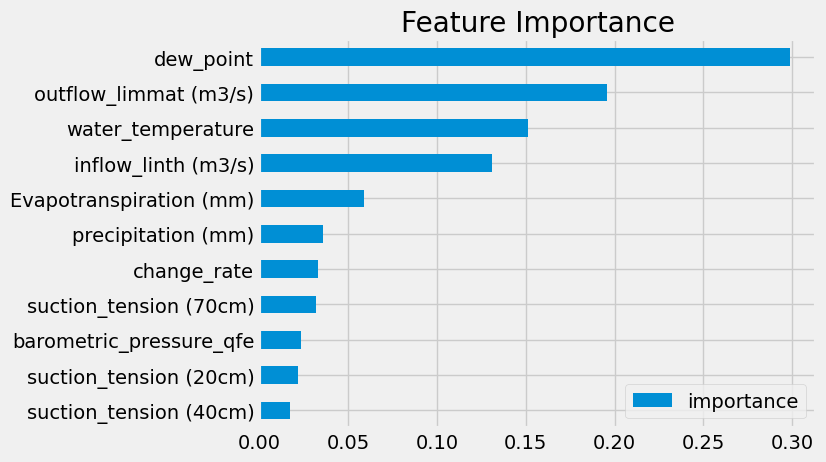

In [72]:
#Plot the feature importance

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on test data

This section looks at how well our model predicts on validation data

In [73]:
for i in range(len(X_list_val)):
    X_list_val[i]['prediction'] = reg.predict(X_list_val[i]) # We create a column prediction in each datasets

In [74]:
# We define a function to see how our prediction does

def plot_pred(x, y, true_col, pred_col, title): 

        fig, ax = plt.subplots(figsize=(12,5))
        ax.grid()
        ax.plot(y, label = true_col)
        ax.plot(x[pred_col], label = pred_col)
        ax.set_title(title)
        ax.legend()    

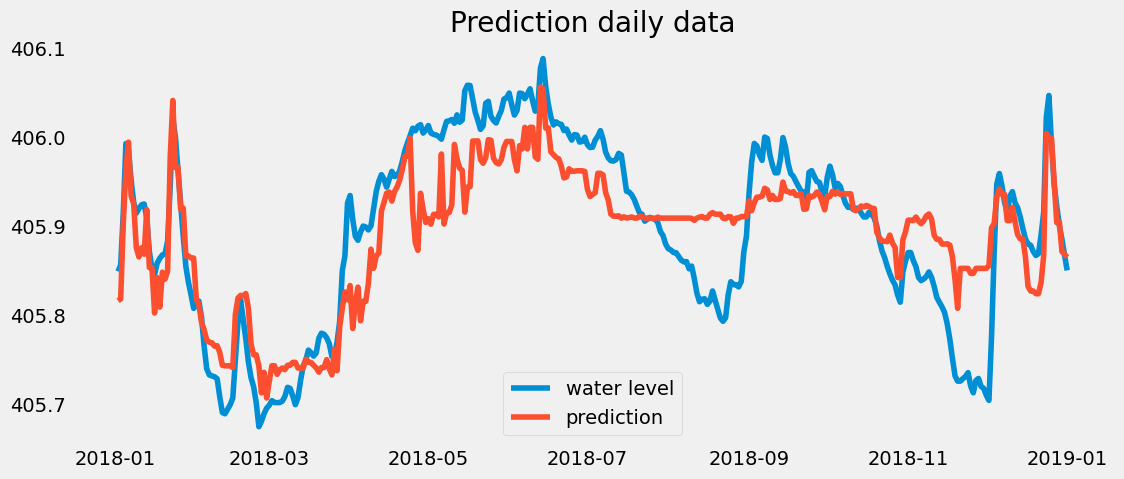

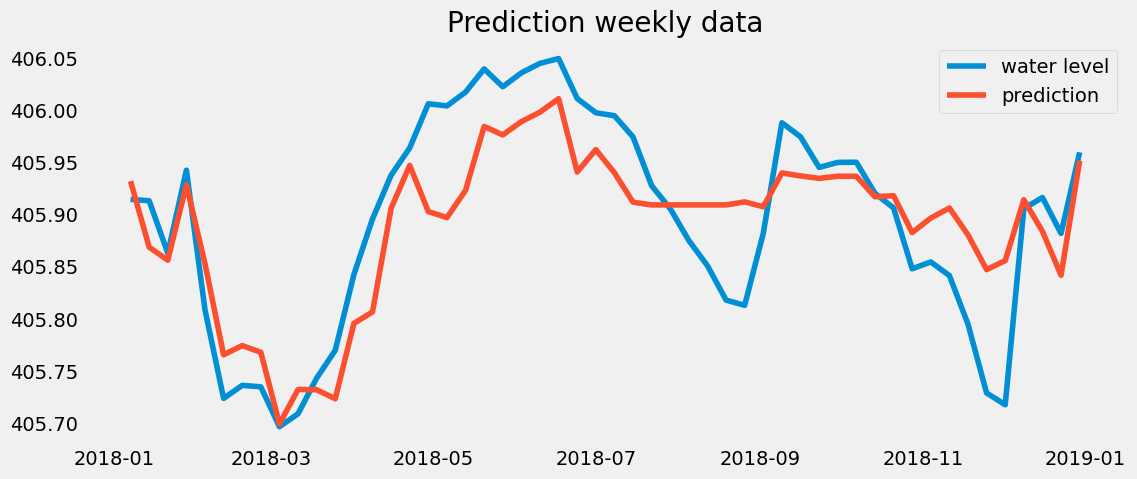

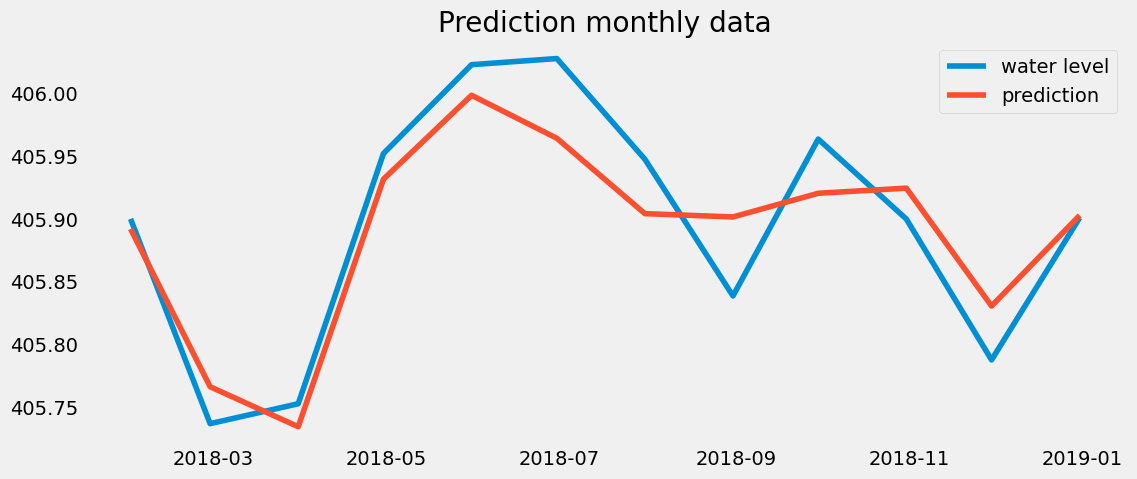

In [75]:
plot_pred(X_list_val[0], y_list_val[0], 'water level', 'prediction', 'Prediction daily data')
plot_pred(X_list_val[1], y_list_val[1], 'water level', 'prediction', 'Prediction weekly data')
plot_pred(X_list_val[2], y_list_val[2], 'water level', 'prediction', 'Prediction monthly data')

# Evaluation metrics

Here we evaluate our predictions

In [76]:
DWM = ['Daily data', 'Weekly data', 'Monthly data'] # A list to make the print clearer

for i in range(len(X_list_val)):
    print(f'{DWM[i]}:')
    mean_errors_print(X_list_val[i]['prediction'], y_list_val[i])

Daily data:
MAE: 0.04463246765600824 
MSE: 0.0030815673429370662 
MAPE: 0.010996225889745715 
R2: 0.42390754569442457
Weekly data:
MAE: 0.04439374092297918 
MSE: 0.0030083206249362777 
MAPE: 0.01093736164904761 
R2: 0.4271864442188775
Monthly data:
MAE: 0.03196058489409381 
MSE: 0.0013764274915525345 
MAPE: 0.007874059700908959 
R2: 0.7454596947660497


# Multiple train/test splits for cross validation

In this section, we use multiple train/test splits of the data to get a better idea of how our model performs on unseen data

In [77]:
from sklearn.model_selection import TimeSeriesSplit

tssD = TimeSeriesSplit(n_splits=5, test_size=300, gap=1) #split for daily data
tssW = TimeSeriesSplit(n_splits=5, test_size=42, gap=1) #split for weekly data
tssM = TimeSeriesSplit(n_splits=5, test_size=10, gap=1) #split for monthly data


In [78]:
# We define a function to visualize our splits

def graph_fold(df, tss, temporal): 
    fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)
    fold = 0
    for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]
        train['water_level'].plot(ax=axs[fold],
                              label='Training Set',
                              title=f'Data Train/Test Split Fold {fold} {temporal}')
        test['water_level'].plot(ax=axs[fold],
                             label='Test Set')
        axs[fold].axvline(test.index.min(), color='black', ls='--')
        fold += 1
    plt.show()

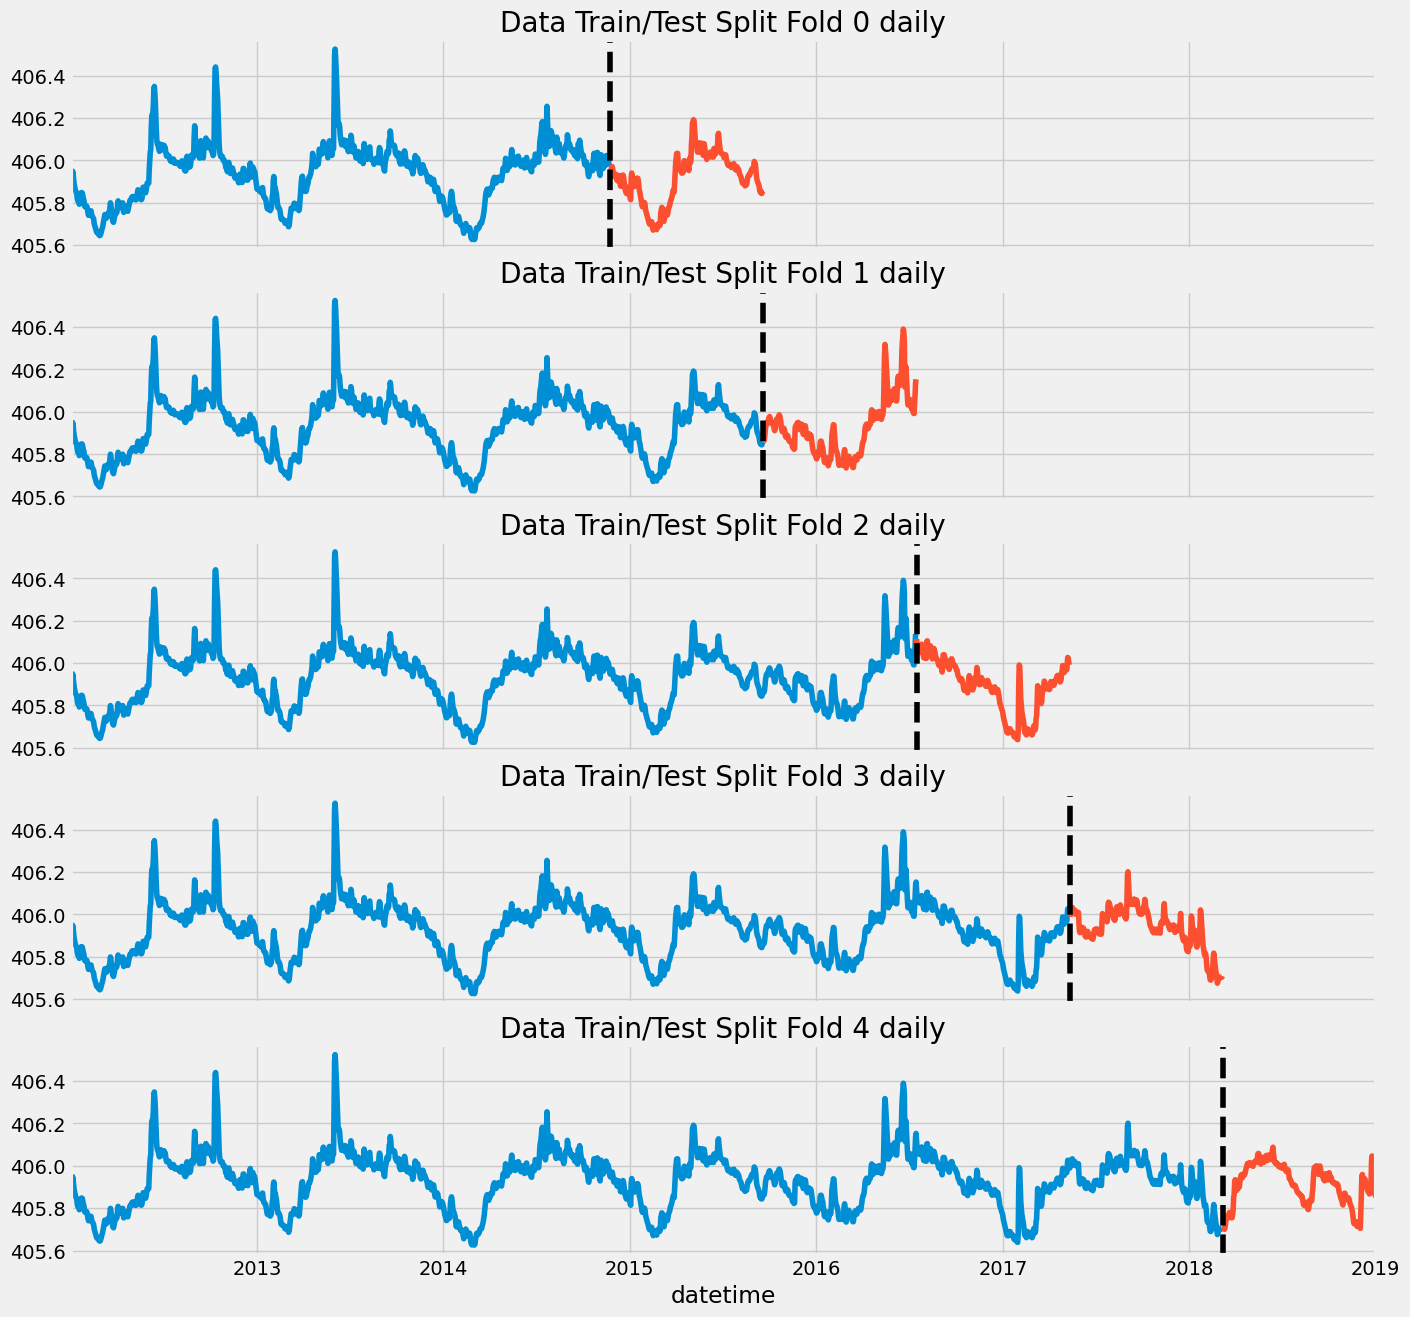

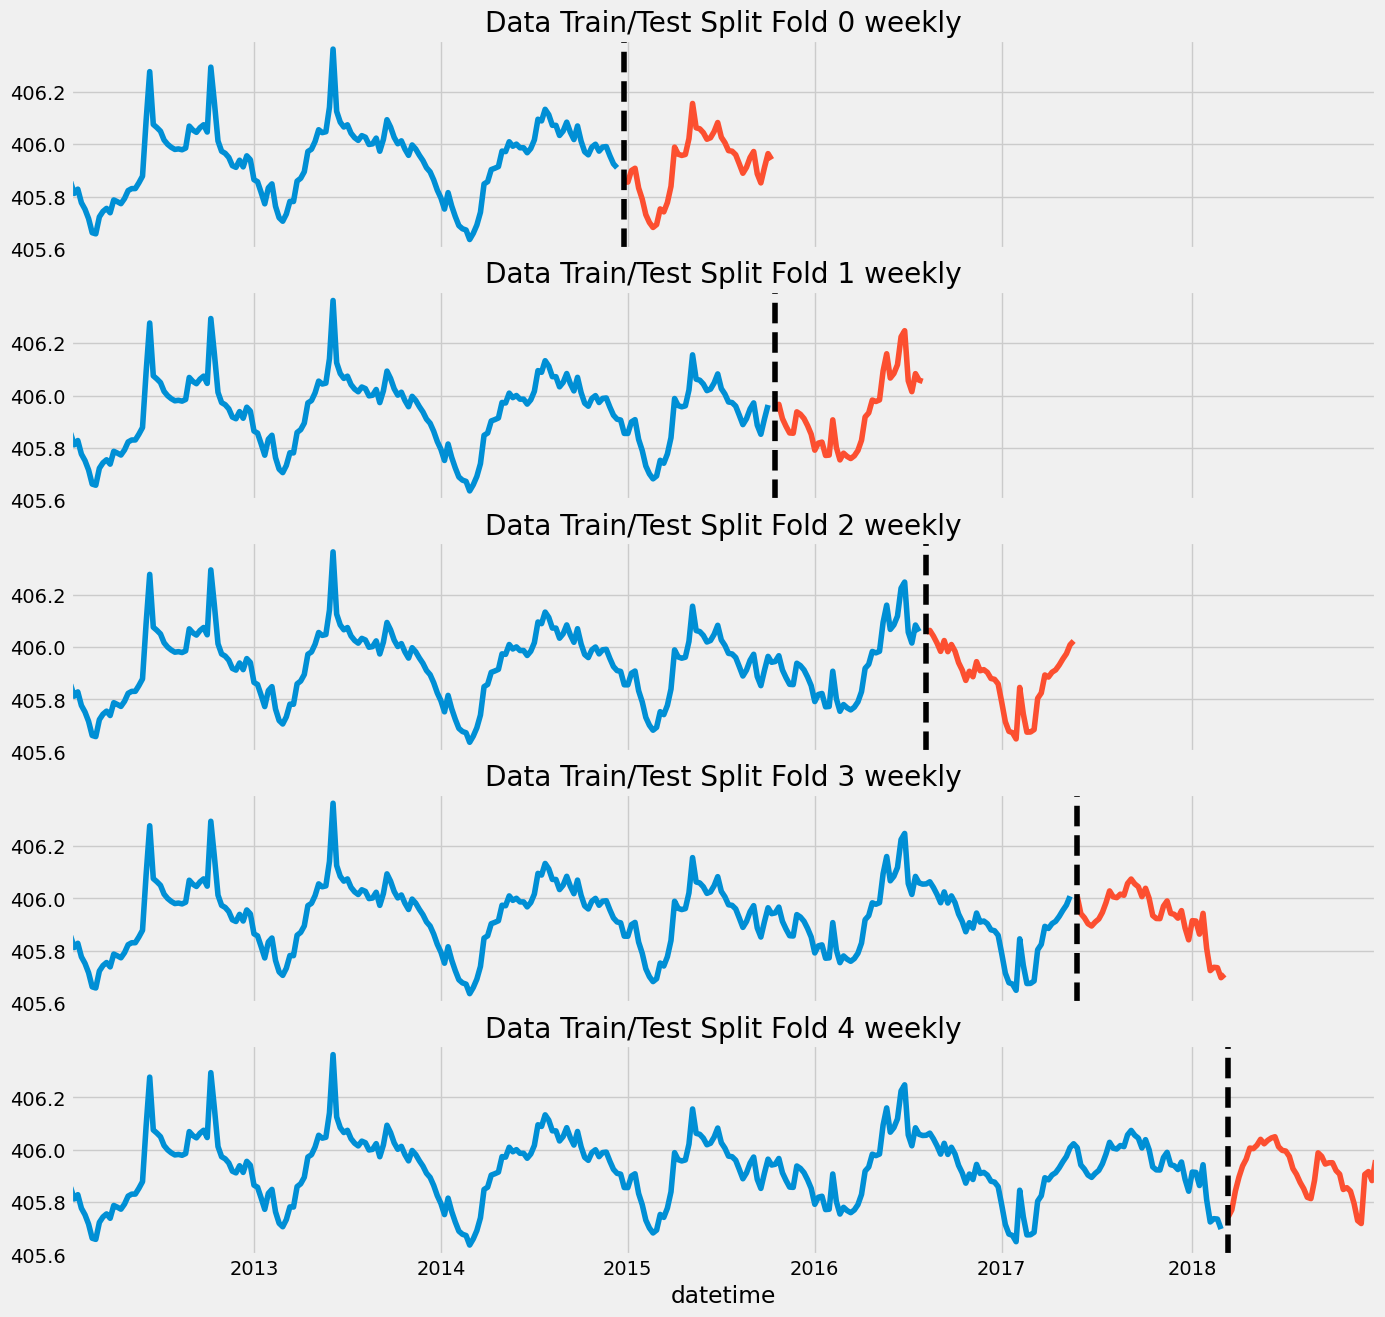

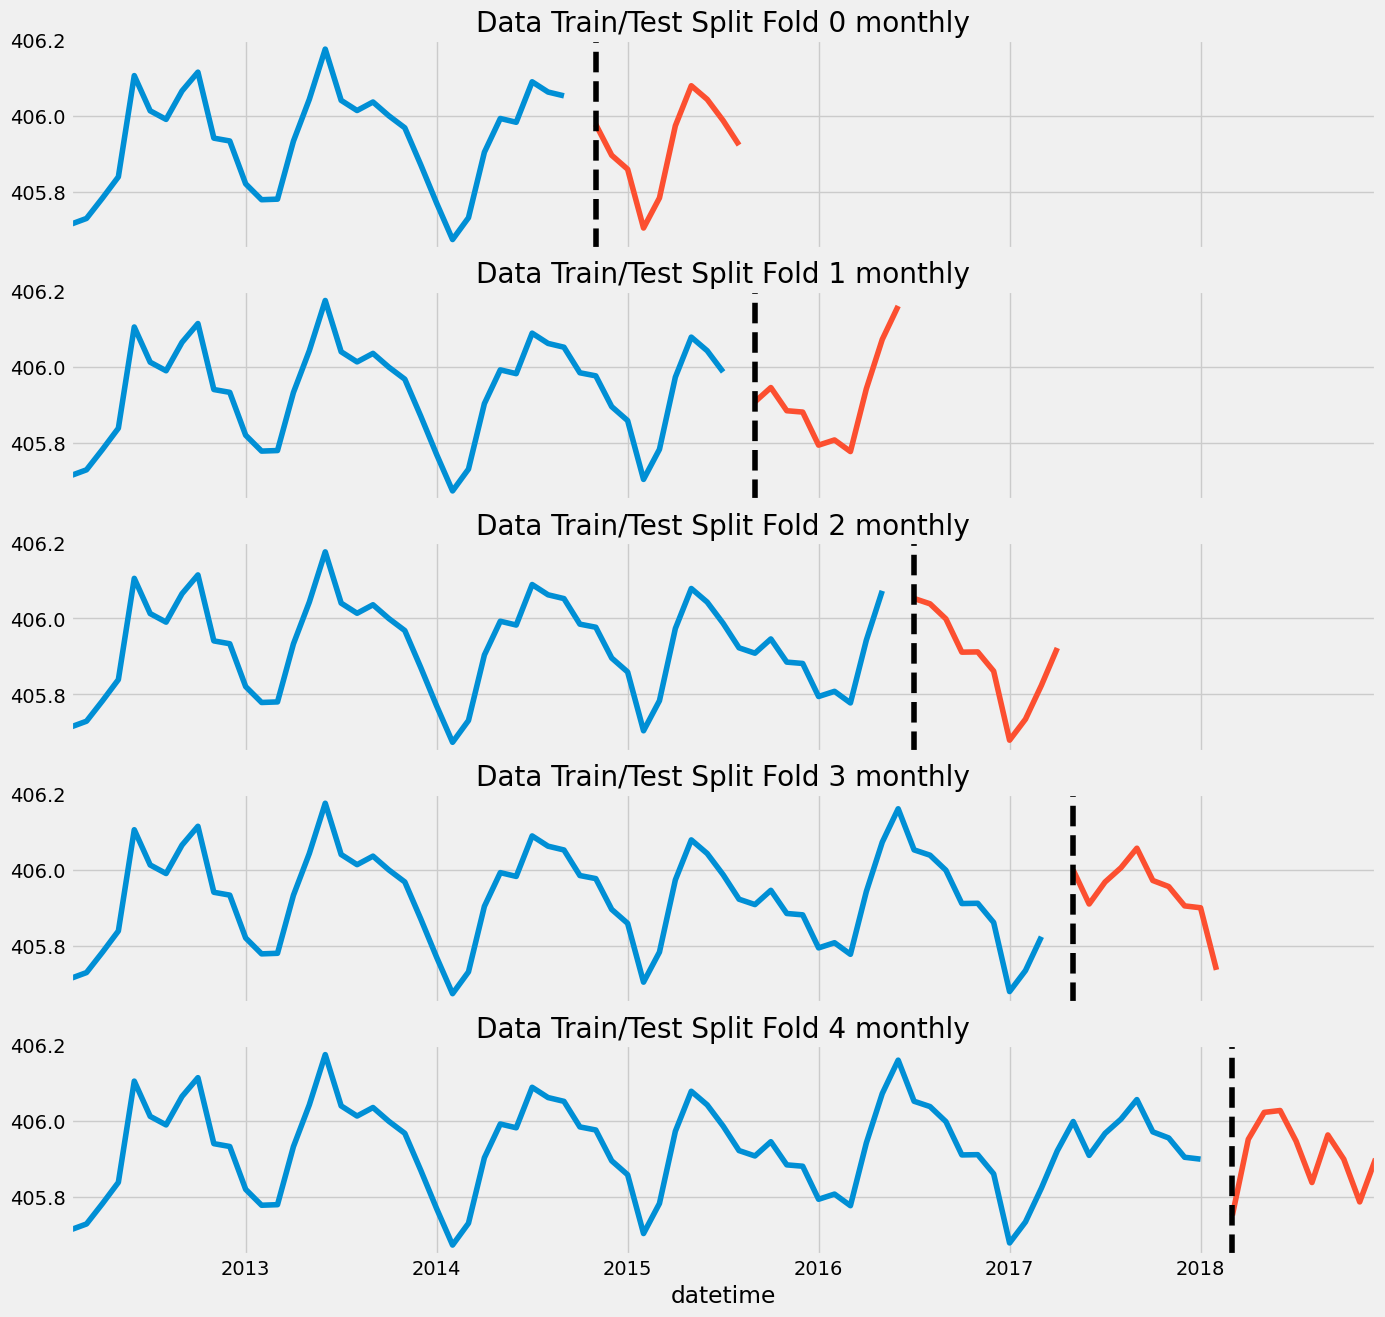

In [79]:
graph_fold(df_list_train_val[0], tssD, 'daily')
graph_fold(df_list_train_val[1], tssW, 'weekly')
graph_fold(df_list_train_val[2], tssM, 'monthly')

# Training and testing with cross validation 

Here we train our model in each different splits

[0]	validation_0-rmse:401.40872	validation_1-rmse:401.39061
[100]	validation_0-rmse:147.89546	validation_1-rmse:147.87733
[200]	validation_0-rmse:54.49090	validation_1-rmse:54.47274
[300]	validation_0-rmse:20.07703	validation_1-rmse:20.05879
[400]	validation_0-rmse:7.39835	validation_1-rmse:7.37987
[500]	validation_0-rmse:2.72881	validation_1-rmse:2.70973
[600]	validation_0-rmse:1.01262	validation_1-rmse:0.99432
[700]	validation_0-rmse:0.38203	validation_1-rmse:0.36322
[800]	validation_0-rmse:0.15108	validation_1-rmse:0.13505
[900]	validation_0-rmse:0.06795	validation_1-rmse:0.06202
[999]	validation_0-rmse:0.03976	validation_1-rmse:0.05106
[0]	validation_0-rmse:401.39906	validation_1-rmse:401.39797
[100]	validation_0-rmse:147.68416	validation_1-rmse:147.68307
[200]	validation_0-rmse:54.33666	validation_1-rmse:54.33558
[300]	validation_0-rmse:19.99221	validation_1-rmse:19.99113
[400]	validation_0-rmse:7.35657	validation_1-rmse:7.35549
[500]	validation_0-rmse:2.70942	validation_1-rmse:2.

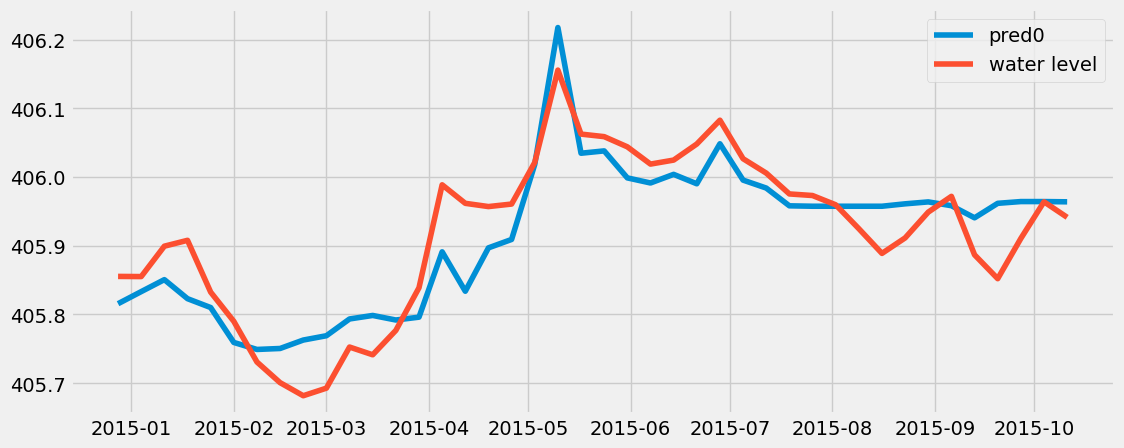

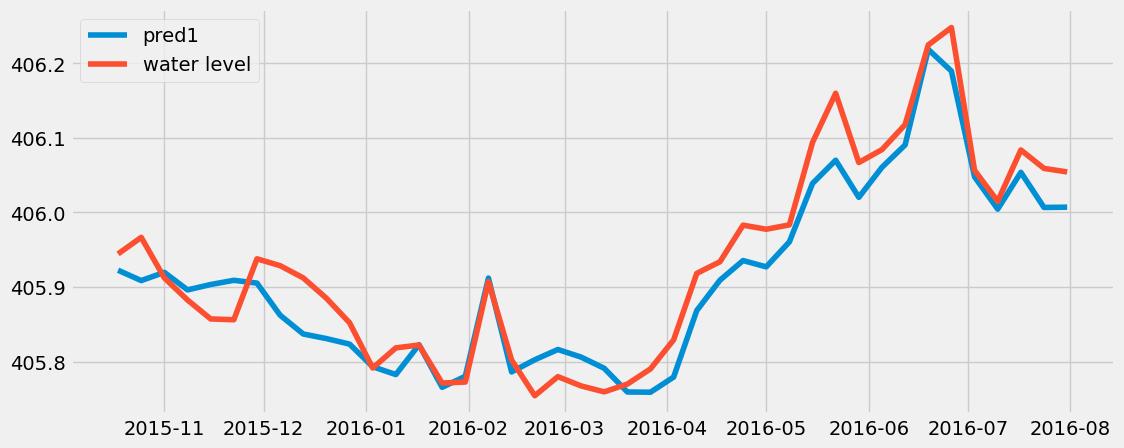

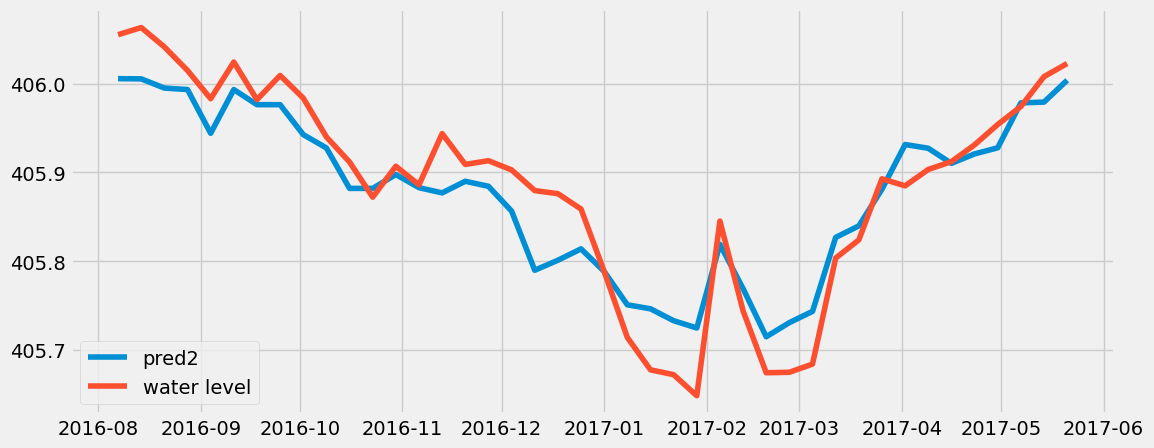

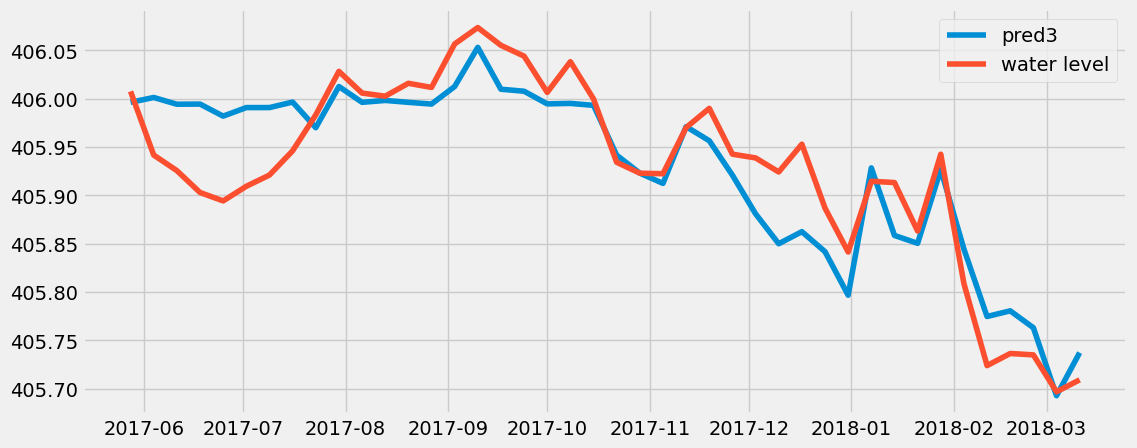

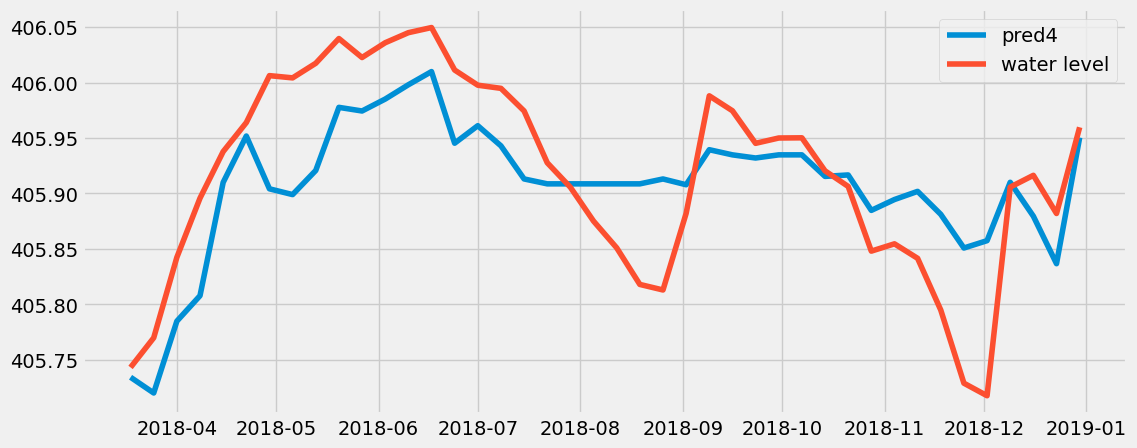

In [80]:

fold = 0
preds = []
scores = []
number = 0
X_list_pred =[]

for train_idx, val_idx in tssW.split(df_list_train_val[1]): # We iterate through each split and retrain our model each time, we are using weekly data
    train = df_list_train_val[1].iloc[train_idx]
    test = df_list_train_val[1].iloc[val_idx]

    X_train = train[Features]
    y_train = train[Target]

    X_test = test[Features]
    y_test = test[Target]
    
    reg = xgb.XGBRegressor(base_score=0.5, # Initial prediction score, global bias
                           booster='gbtree', # The booster used    
                           n_estimators=1000, # The number of gradient boosted trees in our model
                           early_stopping_rounds=50, # We specify when we want our model to stop when we see little improvements, this should help us reduce overfitting
                           objective='reg:squarederror', # The objective function that the model tries to minimize
                           max_depth=3, # Maximum tree depth
                           learning_rate=0.01) # Boosting learning rate 
    
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
    z_test = X_test.copy()
    
    z_test[f"pred{number}"] = reg.predict(X_test)
    
    fig, ax = plt.subplots(figsize = (12, 5))
    
    plt.plot(z_test[f"pred{number}"], label = f"pred{number}") # We plot the results of the prediction of each fold
    plt.plot(y_test, label = "water level")
    ax.legend()
    
    y_pred = reg.predict(X_test)

    preds.append(y_pred)
    score = mean_squared_error(y_test, y_pred)
    scores.append(score)
    number += 1
    
    

plt.show()


In [81]:
print(f'Score across folds {np.mean(scores):0.4f}') # We compute the mean of the mean squared error of each fold to assess how it performs
print(f'Fold scores:{scores}')

Score across folds 0.0023
Fold scores:[0.0025994301725756285, 0.001612982574381499, 0.0016492225761003082, 0.0019367957142441864, 0.003576309676238152]


# Final test


In this section we do our final test on unseen data to see how well our model performs in practice

In [82]:
# We predict for the test data for each frequencies

for df in df_list_test:
    df['pred'] = reg.predict(df[Features])

In [83]:
# We define a function to graph the difference between the predictions and the true values

def graph_predict(df):    
    df['pred'].plot(figsize=(10, 5),
                                   color="red",
                                   title='pred vs truth', label ='prediction')
    df['water_level'].plot(color="blue", label='water level')
    plt.legend()
    plt.show()

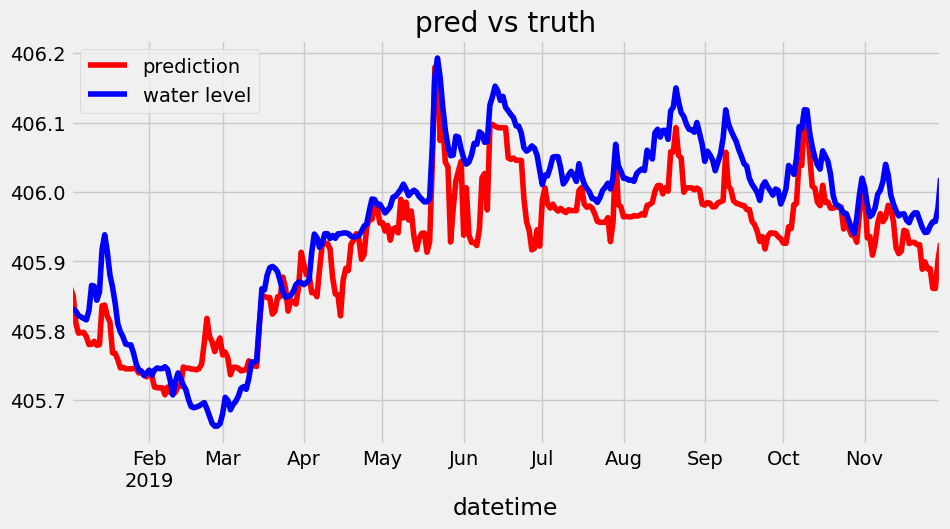

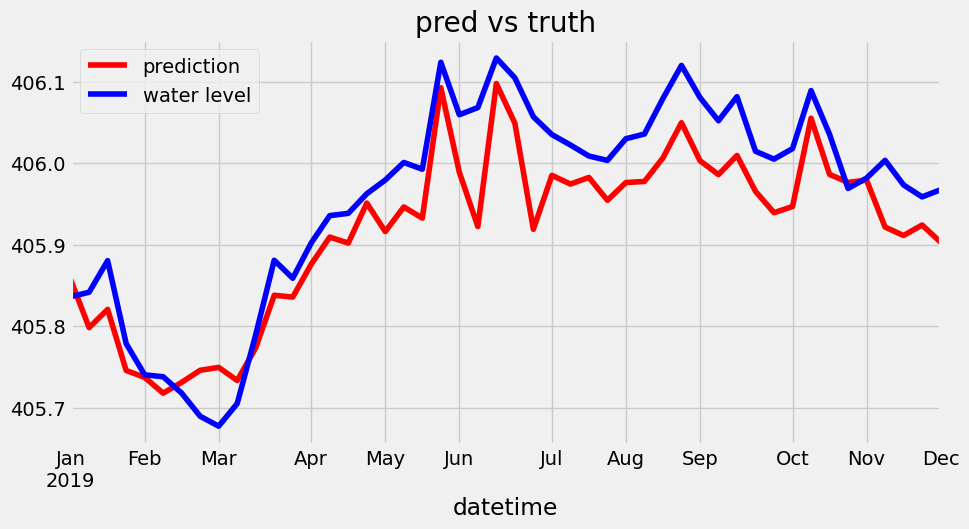

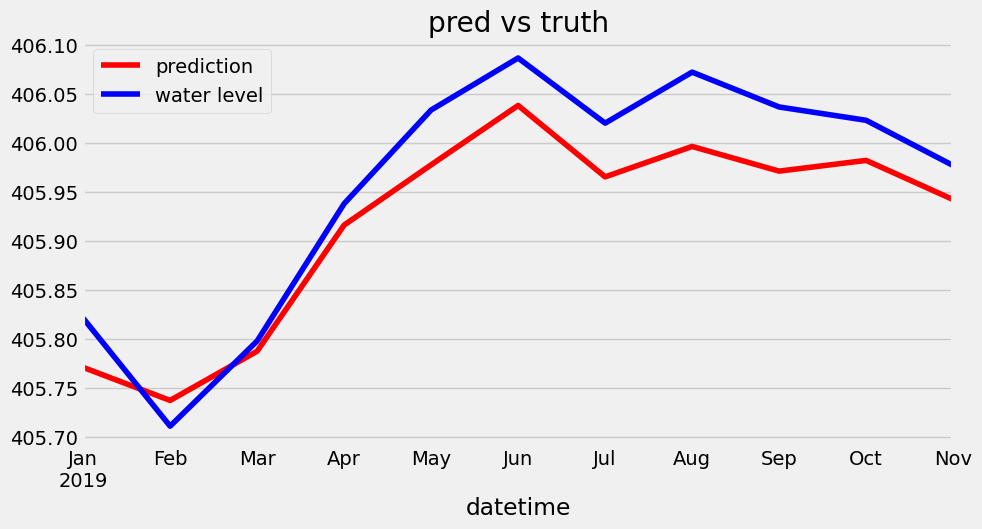

In [84]:
for df in df_list_test:
    graph_predict(df)

In [85]:
# We compute how well our model preformed on the test data
for i in range(len(df_list_test)):
    print(DWM[i])
    mean_errors_print(df_list_test[i]['water_level'], df_list_test[i]['pred'])

Daily data
MAE: 0.050761131085511654 
MSE: 0.0035479560821783623 
MAPE: 0.012503441144414904 
R2: 0.7758058141193748
Weekly data
MAE: 0.04895109138287997 
MSE: 0.003218591253661853 
MAPE: 0.012057297291204675 
R2: 0.7906098913101379
Monthly data
MAE: 0.04411728145526116 
MSE: 0.0022944607310043576 
MAPE: 0.010866595040024919 
R2: 0.8381357700250903


# References

Part of the code comes from: https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost, https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt and https://www.kaggle.com/code/robikscube/pt2-time-series-forecasting-with-xgboost/notebook